# Finetuning with PyTorch


Resources:
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

What's finetuning ?

Which tasks ?


What is CIFAR-10?

https://en.wikipedia.org/wiki/CIFAR-10

The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class

# Downloading the CIFAR-10 dataset

To download the CIFAR-10 dataset, you need to have a Kaggle account and a Kaggle API key.

1. Create a Kaggle account if you don't have one. https://www.kaggle.com/ 

2. Download the dataset
   1. Either manually from https://www.kaggle.com/c/cifar-10/data
   2. Or using the kaggle CLI:
      1. `pip install kaggle` 
      2. Get the API key from https://www.kaggle.com/settings/api 
      3. Move the downloaded file to the approriate folder: https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md#api-credentials
      4. 
      ```bash
      kaggle competitions download -c cifar-10 -p PyTorch/data
      ```


Unzip it in the same folder

```tree
PyTorch/data/CIFAR-10
├── cifar-10.zip
├── sampleSubmission.csv
├── test.7z
├── train.7z
└── trainLabels.csv
```



In [1]:
! tree data/

data/
├── CIFAR-10
│   ├── cifar-10-batches-py
│   │   ├── batches.meta
│   │   ├── data_batch_1
│   │   ├── data_batch_2
│   │   ├── data_batch_3
│   │   ├── data_batch_4
│   │   ├── data_batch_5
│   │   ├── readme.html
│   │   └── test_batch
│   └── cifar-10-python.tar.gz
├── cifar_finetuned_resnet18.pth
└── cifar_net.pth

3 directories, 11 files


Now let's unzip it

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
device_str = "cpu"
if torch.cuda.is_available():
    device_str = "cuda:0"
elif torch.backends.mps.is_available():
    device_str = "mps"
device = torch.device(device_str)
device

device(type='mps')

In [4]:
transform = transforms.Compose(
    [
		transforms.ToTensor(), 
		transforms.Normalize(
			(0.5, 0.5, 0.5), 
			(0.5, 0.5, 0.5)
		),
	]
)

train_dataset = torchvision.datasets.CIFAR10(
	root="./data/CIFAR-10", 
	train=True, 
	download=True,
	transform=transform,
)
test_dataset = torchvision.datasets.CIFAR10(
	root="./data/CIFAR-10", 
	train=False, 
	download=True,
	transform=transform,
)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
	batch_size=batch_size, 
	shuffle=True, 
	num_workers=2,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
	batch_size=batch_size, 
	shuffle=False, 
	num_workers=2,
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

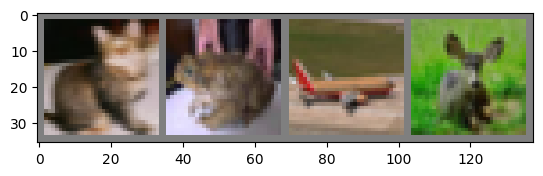

cat        frog       plane      deer      


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(batch_size)))

# Define a Convolutional Neural Network

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# Define a Loss function and optimizer

# Train

## Define the device

In [8]:
def train(net, train_loader, criterion, optimizer, device, epochs=2):
    net.to(device)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
                running_loss = 0.0

    print("Finished Training")

In [9]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(net, train_loader, criterion, optimizer, device, epochs=10)

[1,  2000] loss: 2.195
[1,  4000] loss: 1.832
[1,  6000] loss: 1.688
[1,  8000] loss: 1.583
[1, 10000] loss: 1.522
[1, 12000] loss: 1.463
[2,  2000] loss: 1.414
[2,  4000] loss: 1.370
[2,  6000] loss: 1.349
[2,  8000] loss: 1.343
[2, 10000] loss: 1.296
[2, 12000] loss: 1.277
[3,  2000] loss: 1.225
[3,  4000] loss: 1.226
[3,  6000] loss: 1.206
[3,  8000] loss: 1.226
[3, 10000] loss: 1.198
[3, 12000] loss: 1.188
[4,  2000] loss: 1.112
[4,  4000] loss: 1.107
[4,  6000] loss: 1.119
[4,  8000] loss: 1.123
[4, 10000] loss: 1.108
[4, 12000] loss: 1.128
[5,  2000] loss: 1.036
[5,  4000] loss: 1.027
[5,  6000] loss: 1.067
[5,  8000] loss: 1.052
[5, 10000] loss: 1.065
[5, 12000] loss: 1.080
[6,  2000] loss: 0.948
[6,  4000] loss: 1.000
[6,  6000] loss: 0.996
[6,  8000] loss: 1.013
[6, 10000] loss: 1.021
[6, 12000] loss: 1.004
[7,  2000] loss: 0.924
[7,  4000] loss: 0.943
[7,  6000] loss: 0.964
[7,  8000] loss: 0.949
[7, 10000] loss: 0.962
[7, 12000] loss: 0.982
[8,  2000] loss: 0.862
[8,  4000] 

In [10]:
PATH = "./data/cifar_net.pth"
torch.save(net.state_dict(), PATH)

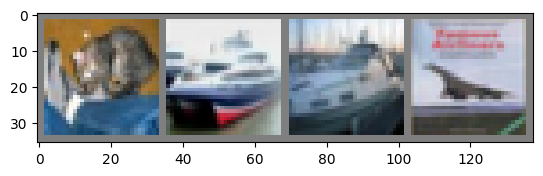

GroundTruth:
 cat        ship       ship       plane     


In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth:\n", " ".join(f"{classes[labels[j]]:10s}" for j in range(4)))

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  cat   ship  ship  plane


In [14]:
def evaluate_model(net, test_loader, device):
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    
    # Compute precision, recall, and f1-score for each class
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    
    print(f"Accuracy of the network on the {total} test images: {accuracy:.2f}%")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-score: {f1score:.4f}")
    
    return accuracy, precision, recall, f1score

# Call the function
accuracy, precision, recall, f1score = evaluate_model(net, test_loader, device)

Accuracy of the network on the 10000 test images: 62.28%
Weighted Precision: 0.6369
Weighted Recall: 0.6228
Weighted F1-score: 0.6258


In [15]:
def evaluate_class_accuracy(net, test_loader, device, classes):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

evaluate_class_accuracy(net, test_loader, device, classes)

Accuracy for class: plane is 68.1 %
Accuracy for class: car   is 69.6 %
Accuracy for class: bird  is 58.0 %
Accuracy for class: cat   is 48.1 %
Accuracy for class: deer  is 61.4 %
Accuracy for class: dog   is 47.9 %
Accuracy for class: frog  is 67.0 %
Accuracy for class: horse is 57.2 %
Accuracy for class: ship  is 81.4 %
Accuracy for class: truck is 64.1 %


In [16]:
# Make a confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(net, test_loader, device, classes):
    # Initialize confusion matrix
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

    # Compute confusion matrix
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                conf_matrix[t.long(), p.long()] += 1

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# plot_confusion_matrix(net, test_loader, device, classes)


In [17]:
class EfficientNetB0(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.efficientnet_b0 = torchvision.models.efficientnet_b0(weights="DEFAULT")
        self.efficientnet_b0.classifier[1] = nn.Linear(
            self.efficientnet_b0.classifier[1].in_features, n_classes
        )

    def forward(self, x):
        return F.log_softmax(self.efficientnet_b0(x), dim=1)

efficientnet = EfficientNetB0(10)
efficientnet

EfficientNetB0(
  (efficientnet_b0): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [18]:
criterion = nn.CrossEntropyLoss()
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

for name, param in efficientnet.named_parameters():
    # print(name)
    if name.startswith("efficientnet_b0.classifier"):
        param.requires_grad = True
        params_to_update_1.append(param)
    elif name.startswith("efficientnet_b0.features.8"):
        param.requires_grad = True
        params_to_update_2.append(param)
    elif name.startswith("efficientnet_b0.features"):
        param.requires_grad = True
        params_to_update_3.append(param)
    else:
        param.requires_grad = False

print(f"{len(params_to_update_1) = }")
print(f"{len(params_to_update_2) = }")
print(f"{len(params_to_update_3) = }")

optimizer = optim.SGD(
    [
        {"params": params_to_update_1, "lr": 1e-3},
        {"params": params_to_update_2, "lr": 5e-4},
        {"params": params_to_update_3, "lr": 1e-4},
    ],
    momentum=0.9,
)

len(params_to_update_1) = 2
len(params_to_update_2) = 3
len(params_to_update_3) = 208


In [19]:
model_path = "./data/cifar_finetuned_efficient_net.pth"
model = efficientnet
if True:
    train(model, train_loader, criterion, optimizer, device, epochs=10)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
evaluate_model(model, test_loader, device)

[1,  2000] loss: 2.418
[1,  4000] loss: 2.481
[1,  6000] loss: 2.481
[1,  8000] loss: 2.444
[1, 10000] loss: 2.368
[1, 12000] loss: 2.311
[2,  2000] loss: 2.212
[2,  4000] loss: 2.179
[2,  6000] loss: 2.171
[2,  8000] loss: 2.145
[2, 10000] loss: 2.097
[2, 12000] loss: 2.090
[3,  2000] loss: 2.074
[3,  4000] loss: 2.061
[3,  6000] loss: 2.065
[3,  8000] loss: 2.062
[3, 10000] loss: 2.034
[3, 12000] loss: 2.029
[4,  2000] loss: 2.032
[4,  4000] loss: 2.015
[4,  6000] loss: 2.003
[4,  8000] loss: 2.004
[4, 10000] loss: 1.989
[4, 12000] loss: 1.968
[5,  2000] loss: 1.999
[5,  4000] loss: 2.013
[5,  6000] loss: 1.970
[5,  8000] loss: 1.960
[5, 10000] loss: 1.969
[5, 12000] loss: 1.958
[6,  2000] loss: 1.976
[6,  4000] loss: 1.941
[6,  6000] loss: 1.959
[6,  8000] loss: 1.934
[6, 10000] loss: 1.941
[6, 12000] loss: 1.947
[7,  2000] loss: 2.002
[7,  4000] loss: 1.981
[7,  6000] loss: 1.973
[7,  8000] loss: 1.962
[7, 10000] loss: 1.959
[7, 12000] loss: 1.936
[8,  2000] loss: 1.962
[8,  4000] 

(29.34,
 np.float64(0.2931245960409082),
 np.float64(0.2934),
 np.float64(0.2755775546079937))

In [20]:
def get_pretrained_net():
    resnet = torchvision.models.resnet18(pretrained=True)
    resnet.train()

    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)

    return resnet

pretrained_net = get_pretrained_net()
pretrained_net

/Users/ezalos/42/Notebooks2Teach/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ezalos/42/Notebooks2Teach/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
criterion = nn.CrossEntropyLoss()
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

for name, param in pretrained_net.named_parameters():
    if name.startswith("fc"):
        param.requires_grad = True
        params_to_update_1.append(param)
    elif name.startswith("layer4"):
        param.requires_grad = True
        params_to_update_2.append(param)
    elif name.startswith("layer"):
        param.requires_grad = True
        params_to_update_3.append(param)
    else:
        param.requires_grad = False

optimizer = optim.SGD(
    [
		{'params': params_to_update_1, 'lr': 1e-3},
		{'params': params_to_update_2, 'lr': 5e-4},
		{'params': params_to_update_3, 'lr': 1e-4},
	],
    momentum=0.9,
)

In [22]:
model_path = "./data/cifar_finetuned_resnet18.pth"
model = pretrained_net

if True:
    train(model, train_loader, criterion, optimizer, device, epochs=10)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
    
evaluate_model(model, test_loader, device)

[1,  2000] loss: 2.629
[1,  4000] loss: 2.248
[1,  6000] loss: 2.094
[1,  8000] loss: 2.045
[1, 10000] loss: 1.933
[1, 12000] loss: 1.876
[2,  2000] loss: 1.775
[2,  4000] loss: 1.728
[2,  6000] loss: 1.650
[2,  8000] loss: 1.661
[2, 10000] loss: 1.630
[2, 12000] loss: 1.523
[3,  2000] loss: 1.489
[3,  4000] loss: 1.485
[3,  6000] loss: 1.478
[3,  8000] loss: 1.459
[3, 10000] loss: 1.439
[3, 12000] loss: 1.438
[4,  2000] loss: 1.363
[4,  4000] loss: 1.359
[4,  6000] loss: 1.322
[4,  8000] loss: 1.360
[4, 10000] loss: 1.322
[4, 12000] loss: 1.304
[5,  2000] loss: 1.269
[5,  4000] loss: 1.230
[5,  6000] loss: 1.196
[5,  8000] loss: 1.171
[5, 10000] loss: 1.153
[5, 12000] loss: 1.191
[6,  2000] loss: 1.172
[6,  4000] loss: 1.116
[6,  6000] loss: 1.204
[6,  8000] loss: 1.160
[6, 10000] loss: 1.093
[6, 12000] loss: 1.112
[7,  2000] loss: 1.099
[7,  4000] loss: 1.083
[7,  6000] loss: 1.017
[7,  8000] loss: 1.031
[7, 10000] loss: 0.999
[7, 12000] loss: 1.038
[8,  2000] loss: 0.962
[8,  4000] 

(66.45,
 np.float64(0.6837057135848125),
 np.float64(0.6645),
 np.float64(0.6595700497415329))

Accuracy of the network on the 10000 test images: 66.45%
Weighted Precision: 0.6837
Weighted Recall: 0.6645
Weighted F1-score: 0.6596


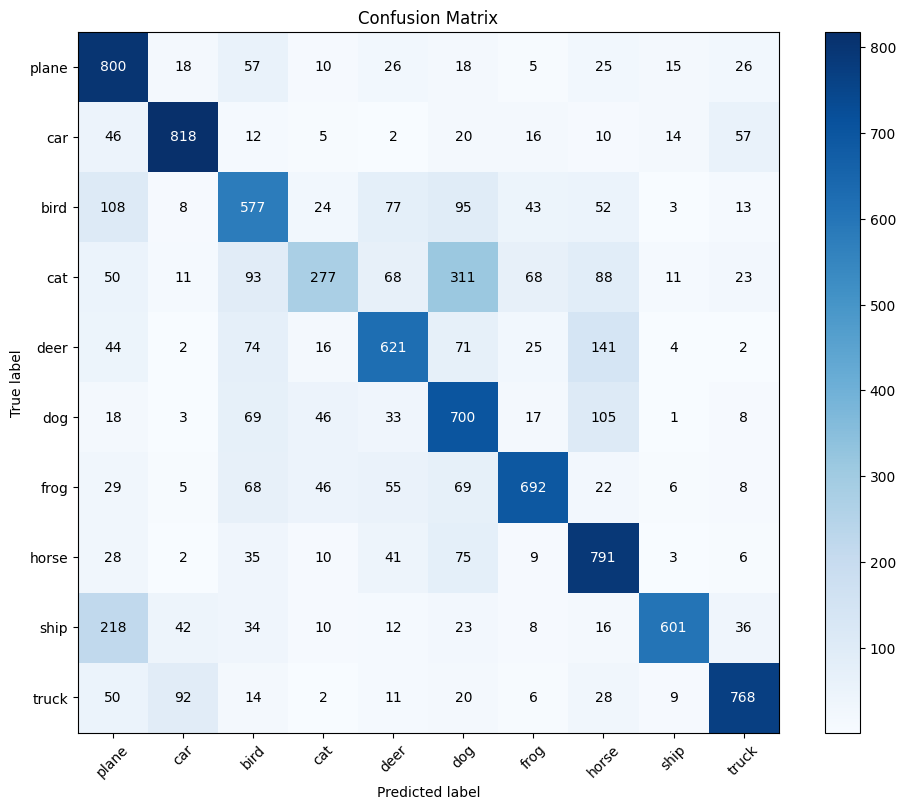

In [23]:
evaluate_model(pretrained_net, test_loader, device)
plot_confusion_matrix(pretrained_net, test_loader, device, classes)

In [24]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobile_net.train()
mobile_net.classifier[1] = torch.nn.Linear(mobile_net.classifier[1].in_features, 10)
torch.nn.init.xavier_uniform_(mobile_net.classifier[1].weight)
mobile_net

Using cache found in /Users/ezalos/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/ezalos/42/Notebooks2Teach/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ezalos/42/Notebooks2Teach/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [25]:
criterion = nn.CrossEntropyLoss()
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

for name, param in mobile_net.named_parameters():
    if name.startswith("classifier"):
        param.requires_grad = True
        params_to_update_1.append(param)
    # elif name.startswith("features"):
    #     param.requires_grad = True
    #     params_to_update_2.append(param)
    elif name.startswith("features"):
        param.requires_grad = True
        params_to_update_3.append(param)
    else:
        param.requires_grad = False

print(f"{len(params_to_update_1) = }")
print(f"{len(params_to_update_2) = }")
print(f"{len(params_to_update_3) = }")

optimizer = optim.SGD(
    [
        {"params": params_to_update_1, "lr": 1e-3},
        {"params": params_to_update_2, "lr": 5e-4},
        {"params": params_to_update_3, "lr": 1e-4},
    ],
    momentum=0.9,
)

len(params_to_update_1) = 2
len(params_to_update_2) = 0
len(params_to_update_3) = 156


In [26]:
model_path = "./data/cifar_finetuned_mobile_net.pth"
model = mobile_net

if True:
    train(model, train_loader, criterion, optimizer, device, epochs=10)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
evaluate_model(model, test_loader, device)

train(mobile_net, train_loader, criterion, optimizer, device, epochs=10)

[1,  2000] loss: 3.442
[1,  4000] loss: 3.247
[1,  6000] loss: 3.019
[1,  8000] loss: 2.868
[1, 10000] loss: 2.767
[1, 12000] loss: 2.714
[2,  2000] loss: 2.651
[2,  4000] loss: 2.632
[2,  6000] loss: 2.595
[2,  8000] loss: 2.582
[2, 10000] loss: 2.553
[2, 12000] loss: 2.539
[3,  2000] loss: 2.544
[3,  4000] loss: 2.573
[3,  6000] loss: 2.511
[3,  8000] loss: 2.480
[3, 10000] loss: 2.538
[3, 12000] loss: 2.483
[4,  2000] loss: 2.506
[4,  4000] loss: 2.497
[4,  6000] loss: 2.486
[4,  8000] loss: 2.477
[4, 10000] loss: 2.501
[4, 12000] loss: 2.525
[5,  2000] loss: 2.495
[5,  4000] loss: 2.441
[5,  6000] loss: 2.415
[5,  8000] loss: 2.449
[5, 10000] loss: 2.406
[5, 12000] loss: 2.375
[6,  2000] loss: 2.393
[6,  4000] loss: 2.393
[6,  6000] loss: 2.436
[6,  8000] loss: 2.428
[6, 10000] loss: 2.397
[6, 12000] loss: 2.437
[7,  2000] loss: 2.421
[7,  4000] loss: 2.440
[7,  6000] loss: 2.399
[7,  8000] loss: 2.384
[7, 10000] loss: 2.375
[7, 12000] loss: 2.457
[8,  2000] loss: 2.423
[8,  4000] 